In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn

from model import Net
from training import NumpyDataset

import matplotlib.pyplot as plt

In [2]:
# Paths to the model and data
model_path = "/home/arthur/Desktop/Code/warmstart-mpc/example/trained_model_5000.pth"

# Load data from .npy file
data = np.load(
    "/home/arthur/Desktop/Code/warmstart-mpc/example/results_ball_5000.npy",
    allow_pickle=True,
)
T = len(data[0, 2])
nq = len(data[0, 0])
net = Net(nq, T)


In [3]:
# Load the model state
if os.path.exists(model_path):
    net.load_state_dict(torch.load(model_path))
    print("Model loaded successfully.")
else:
    print("Model file does not exist.")
    exit()


Model loaded successfully.


In [4]:
# Create dataset and dataloader
dataset = NumpyDataset(data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [8]:
data[53][2]

array([[-1.0804473 , -1.12987052,  0.23887809, -1.35014567,  1.0326046 ,
         1.47554925,  2.12593491],
       [-0.96001442, -1.03420336,  0.25778731, -1.3511036 ,  0.90890291,
         1.55097967,  2.01803953],
       [-0.83958154, -0.93853619,  0.27669653, -1.35206153,  0.78520122,
         1.62641009,  1.91014414],
       [-0.71914865, -0.84286903,  0.29560574, -1.35301946,  0.66149952,
         1.70184051,  1.80224876],
       [-0.59871577, -0.74720186,  0.31451496, -1.35397738,  0.53779783,
         1.77727093,  1.69435337],
       [-0.47828289, -0.6515347 ,  0.33342418, -1.35493531,  0.41409613,
         1.85270134,  1.58645799],
       [-0.35785   , -0.55586753,  0.3523334 , -1.35589324,  0.29039444,
         1.92813176,  1.4785626 ],
       [-0.23741712, -0.46020037,  0.37124262, -1.35685116,  0.16669274,
         2.00356218,  1.37066722],
       [-0.11698424, -0.3645332 ,  0.39015183, -1.35780909,  0.04299105,
         2.0789926 ,  1.26277183],
       [ 0.00344864, -0.2688

In [7]:
# Set the model to evaluation mode
net.eval()


Net(
  (fc1): Linear(in_features=14, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=140, bias=True)
)

Diff is the squared difference between the prediction and the actual value

In [8]:
# Initialize lists to store predictions and actual values
predictions = []
actuals = []
diff = []

# Make predictions and compare with actual values
with torch.no_grad():
    for inputs, actual in dataloader:
        output = net(inputs)
        diff.append((output.numpy()[0] - actual.numpy()[0])**2)
        predictions.append(output)
        actuals.append(actual)

In [9]:
mean_diff = np.mean(diff, axis=0)
std_diff = np.std(diff, axis=0)

In [10]:
std_diff[0]

array([0.0108563 , 0.00834432, 0.01135632, 0.00633126, 0.0157512 ,
       0.009721  , 0.01341879], dtype=float32)

In [11]:
mean_diff[0]

array([0.00567001, 0.00415328, 0.00667656, 0.00388466, 0.01199916,
       0.00476773, 0.00705254], dtype=float32)

Let's plot the difference of a given sample :

In [12]:
from collections import defaultdict 

q = defaultdict(list)
q_sup_std = defaultdict(list)
q_inf_std = defaultdict(list)
for config_t, std_config_t in zip(mean_diff, std_diff):
    for i, (q_i, std_q_i) in enumerate(zip(config_t, std_config_t)):
        q[f"q_{i}"].append(q_i)
        q_sup_std[f"q_{i}"].append(q_i + std_q_i)
        q_inf_std[f"q_{i}"].append(q_i - std_q_i)


In [13]:
len(q_sup_std["q_1"])

20

Plotting the result

[-0.0051862895, -0.0064309835, -0.007278494, -0.01295015, -0.02543182, -0.04218625, -0.06255698, -0.084886804, -0.11350869, -0.14116871, -0.17555733, -0.20847972, -0.23483051, -0.25911278, -0.25666493, -0.2606934, -0.26942882, -0.27190578, -0.27037978, -0.2512922]
[-0.004191032, -0.003738583, -0.0042883297, -0.005758675, -0.008808121, -0.01564617, -0.022805423, -0.032271035, -0.039959848, -0.055899374, -0.06792374, -0.088836044, -0.10317181, -0.11571749, -0.12903412, -0.13921294, -0.15376699, -0.14918876, -0.14628318, -0.13833791]
[-0.0046797595, -0.0041739387, -0.0051399176, -0.010360159, -0.021333955, -0.032500513, -0.052822966, -0.07498064, -0.09693927, -0.124359384, -0.15596882, -0.19158639, -0.22550127, -0.26602894, -0.30691582, -0.33975676, -0.37578416, -0.40170157, -0.4258585, -0.44933116]
[-0.0024466016, -0.002766411, -0.004546902, -0.009154191, -0.016795572, -0.027211098, -0.040009197, -0.05489728, -0.07496626, -0.09443943, -0.11420714, -0.11332676, -0.12109773, -0.11450482, -

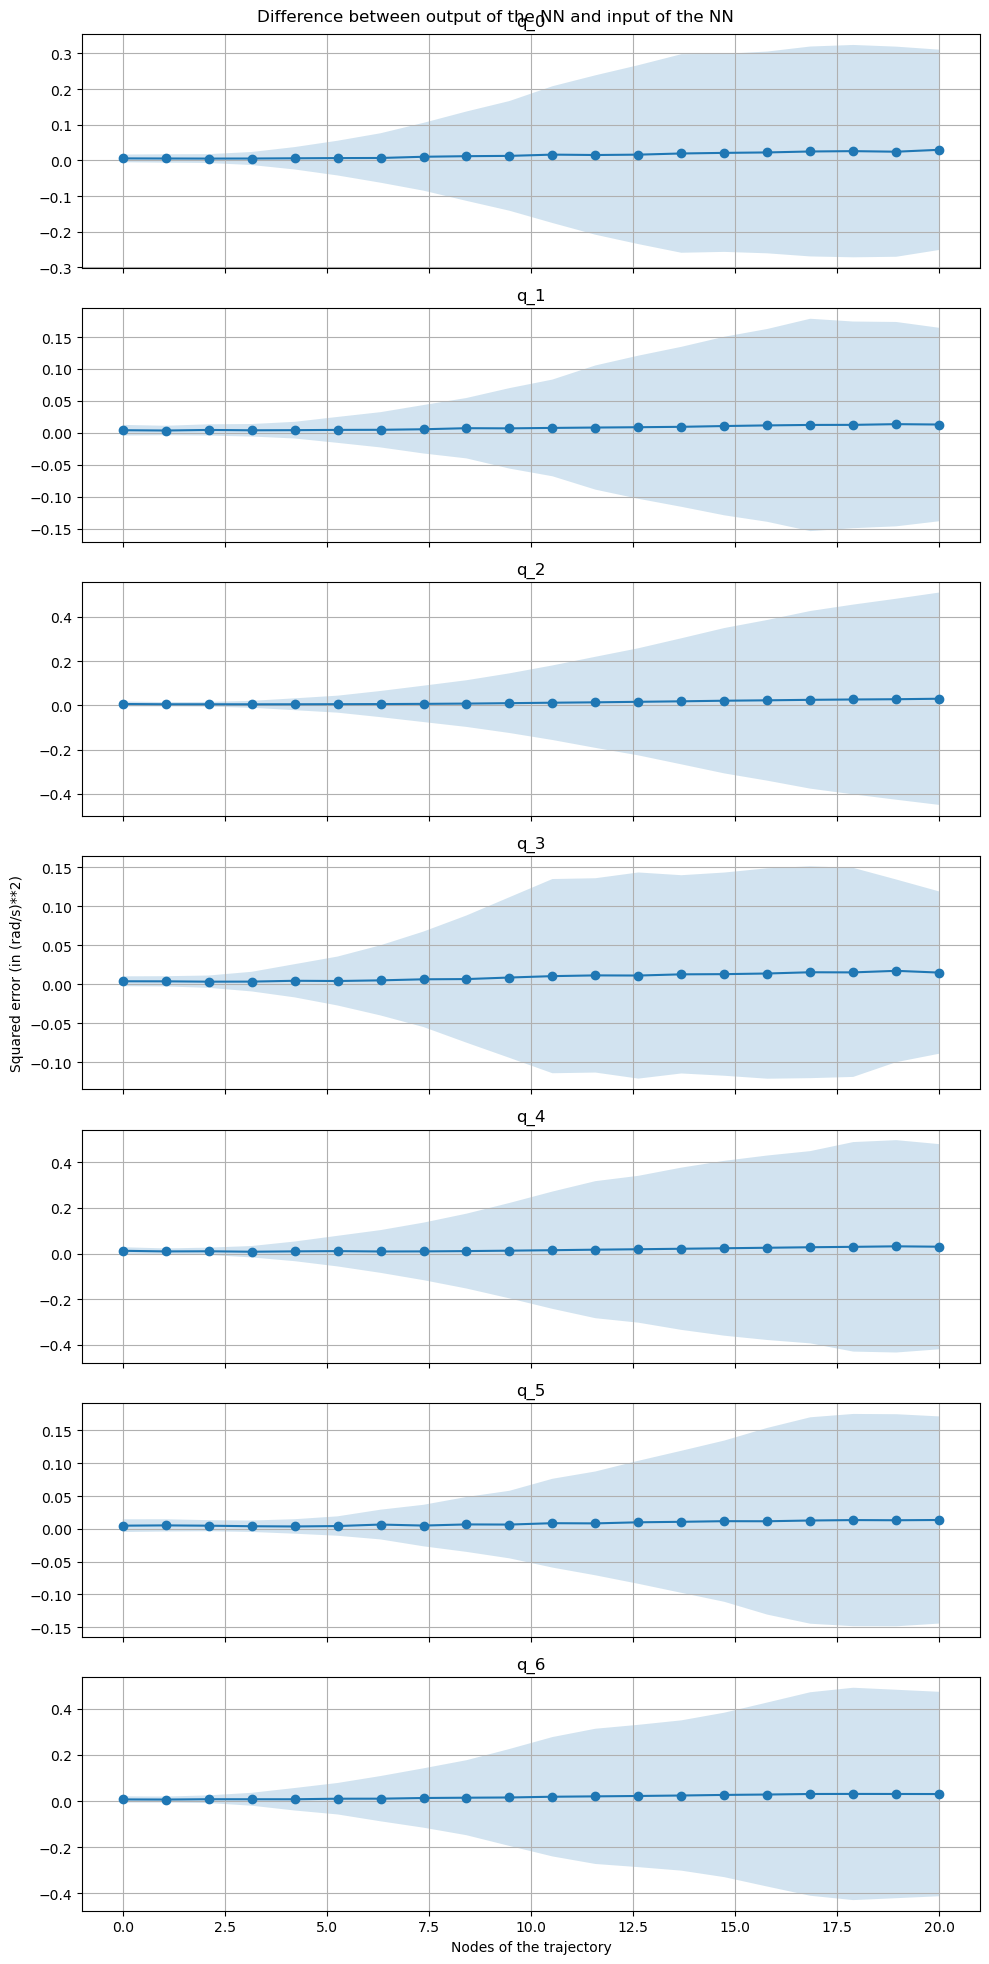

In [14]:
fig, axes = plt.subplots(7, 1, figsize=(10, 20), sharex=True)
nodes = np.linspace(0,len(q["q_0"]), len(q["q_0"]))
for i, (((key, q_i),q_i_inf), q_i_sup) in enumerate(zip(zip(q.items(), q_inf_std.values()), q_sup_std.values())):
    print(q_i_inf)
    axes[i].plot(nodes,q_i, "-o")
    axes[i].fill_between(nodes, q_i_inf, q_i_sup, alpha=0.2, label=f'{key} ± std')
    axes[i].set_title(key)
    axes[i].set_title(key)

    axes[i].grid("on")
axes[3].set_ylabel("Squared error (in (rad/s)**2)")
axes[-1].set_xlabel("Nodes of the trajectory")
plt.suptitle("Difference between output of the NN and input of the NN")
plt.tight_layout()
# plt.show()

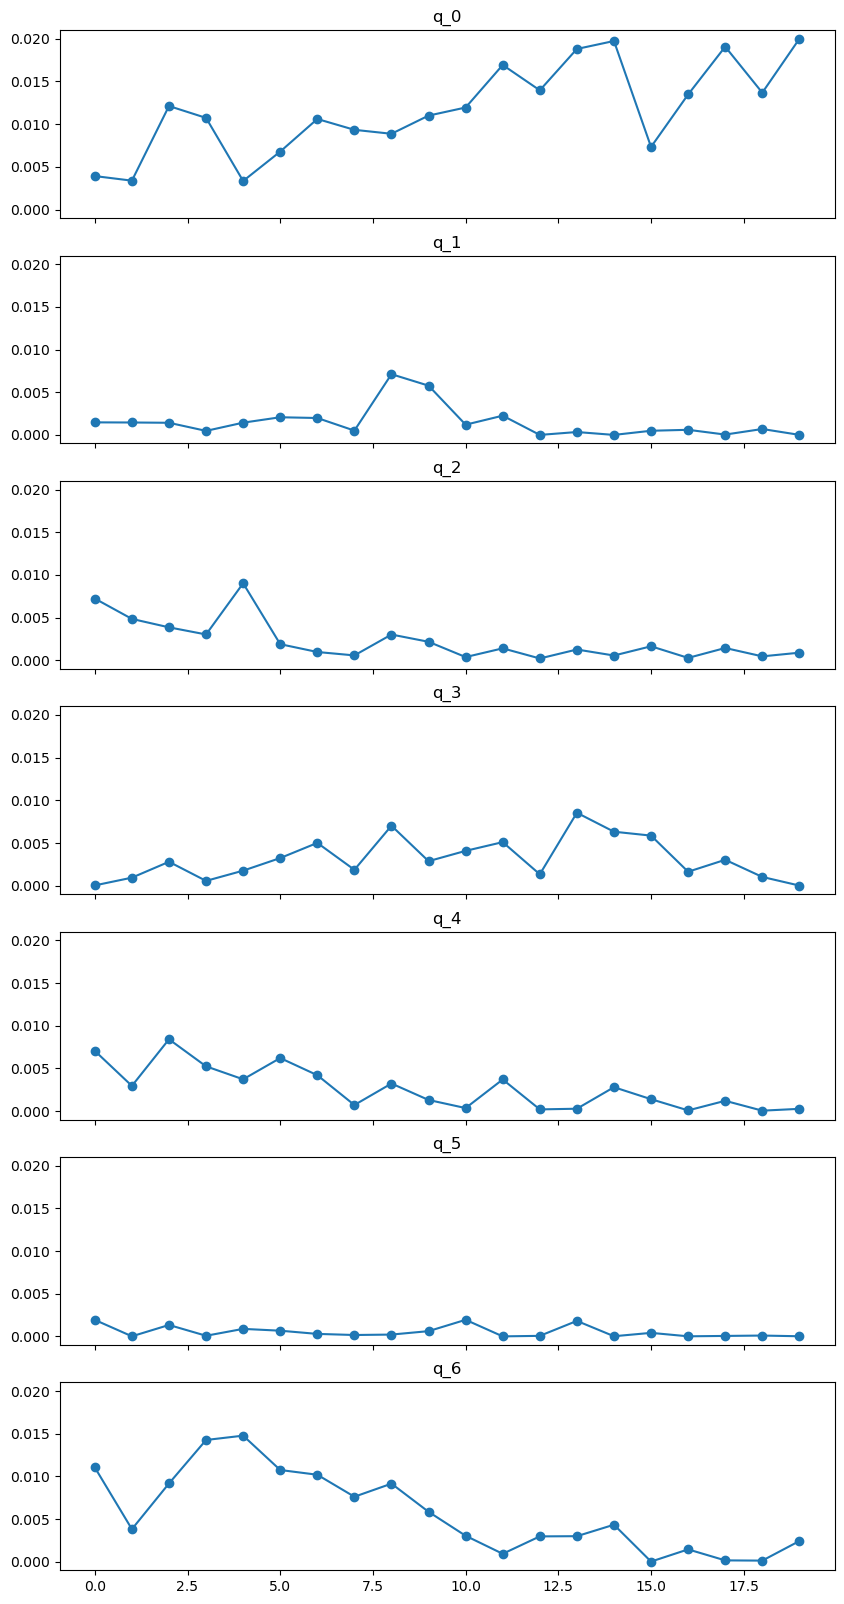

In [19]:
diff_60 = diff[80]
q = defaultdict(list)
for config_t in diff_60:
    for i, q_i in enumerate(config_t):
        q[f"q_{i}"].append(q_i)
fig, axes = plt.subplots(7, 1, figsize=(10, 20), sharex=True, sharey=True)
for i, (key, q_i) in enumerate(q.items()):
    axes[i].plot(q_i, "-o")
    axes[i].set_title(key)